In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import networkx as nx
import random
from importlib import reload
import warnings
import ot
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import ListedColormap

import surprise as sup

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

"""WARNING: no warnings"""
warnings.filterwarnings("ignore")

# local imports
import anndata_utils as anntools

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

In [2]:
# load ann data
resolution = 1000000
population_path = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/population_mESC_{resolution}_anndata.h5ad"

start_time = time.time()  # Record the start time
adata = sc.read_h5ad(population_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()

# sort the object by global bin id
sorted_indices = adata.obs['bin'].argsort()
adata = adata[sorted_indices, :] 

adata

Time taken to read the file: 5.39 seconds
Memory usage: current 1.53 GB, difference +1.53 GB


View of AnnData object with n_obs × n_vars = 2579 × 2756467
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes'
    uns: 'base_resolution', 'chrom_sizes'

In [3]:
adata.obs.head()

,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,ATACSeq_1,...,ATACSeq_3,CTCF,H3K27ac,H3K27me3,RNA_1,RNA_2,RNA_3,RNA_4,RNA_5,RNA_6
bin_name,,,,,,,,,,,,,,,,,,,,,
chr1:3,2235,3000000,4000000,3,1,3,2953,Gm37363;Gm37381;Gm7341;Gm38148;Gm37180;Gm19938...,15,0.507852,...,0.375103,0.319337,0.211256,0.577305,0.263153,0.203017,0.128587,0.271721,0.124134,0.093115
chr1:4,964,4000000,5000000,4,1,4,3331,Gm7369;A930006A01Rik;Gm37381;Gm38076;Mrpl15;Gm...,22,0.680719,...,0.586783,0.561063,0.698206,0.735207,0.282745,0.706667,0.265677,0.247106,0.684904,0.225147
chr1:5,1823,5000000,6000000,5,1,5,3341,Atp6v1h;Gm17101;Gm16041;Rgs20;Gm36965;Gm38264;...,12,0.567134,...,0.467917,0.426098,0.410865,0.458616,0.197587,0.273313,0.233012,0.157297,0.282102,0.108284
chr1:6,1288,6000000,7000000,6,1,6,3422,St18;Gm7449;Gm19214;Gm37108;Gm2147;Gm19026;473...,10,0.621495,...,0.493767,0.474813,0.412592,0.640384,0.209920,0.285676,0.147348,0.170128,0.248226,0.116792
chr1:7,144,7000000,8000000,7,1,7,3289,Gm23274;Gm5694;Rps2-ps2;Gm37225;Gm37489;Gm2690...,18,0.497991,...,0.427530,0.387846,0.458324,0.391387,0.229293,0.227452,0.157668,0.166332,0.212388,0.116124


In [4]:
def find_outliers(df_column):
  """
  Identifies outliers in a pandas DataFrame column using the IQR method.

  Args:
    df_column: A pandas Series representing the column to analyze.

  Returns:
    A boolean mask with True for outliers and False otherwise.
  """
  Q1 = df_column.quantile(0.15)
  Q3 = df_column.quantile(0.85)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return (df_column < lower_bound) | (df_column > upper_bound)

adata.obs['degree_outlier'] = find_outliers(adata.obs['degree'])

print(adata.obs['degree_outlier'].value_counts())

# remove outliers
remove_bins = adata.obs[adata.obs['degree_outlier']].index.to_list()
print(f"Removing top {len(remove_bins)} outlier loci: ")
print(remove_bins)

adata = adata[~adata.obs_names.isin(remove_bins), :].copy()

print('done!')

degree_outlier
False    2431
True      148
Name: count, dtype: int64
Removing top 148 outlier loci: 
['chr1:24', 'chr1:85', 'chr1:195', 'chr2:98', 'chr2:177', 'chr4:112', 'chr4:145', 'chr4:146', 'chr4:147', 'chr5:94', 'chr5:95', 'chr6:103', 'chr7:20', 'chr7:21', 'chr7:22', 'chr7:32', 'chr8:19', 'chr8:20', 'chr8:21', 'chr8:70', 'chr8:130', 'chr9:3', 'chr9:35', 'chr9:124', 'chr10:130', 'chr11:3', 'chr12:3', 'chr13:65', 'chr13:66', 'chr14:3', 'chr14:15', 'chr14:16', 'chr14:17', 'chr14:18', 'chr14:19', 'chr14:125', 'chr16:3', 'chr17:95', 'chr19:61', 'chrX:6', 'chrX:8', 'chrX:9', 'chrX:10', 'chrX:14', 'chrX:15', 'chrX:16', 'chrX:17', 'chrX:18', 'chrX:19', 'chrX:22', 'chrX:23', 'chrX:24', 'chrX:25', 'chrX:26', 'chrX:27', 'chrX:29', 'chrX:34', 'chrX:38', 'chrX:39', 'chrX:40', 'chrX:42', 'chrX:43', 'chrX:44', 'chrX:45', 'chrX:46', 'chrX:48', 'chrX:49', 'chrX:53', 'chrX:54', 'chrX:57', 'chrX:58', 'chrX:60', 'chrX:61', 'chrX:62', 'chrX:63', 'chrX:64', 'chrX:65', 'chrX:66', 'chrX:67', 'chrX:68', 

# Load the core scores 

In [5]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/global_core_score/population_mESC_1000000_scores.csv"
df = pd.read_csv(fpath)
print(f"{df.shape=}")

columns_to_drop = [x for x in df.columns if x in adata.obs.columns]
df = df.drop(columns=columns_to_drop)
print(f"{df.shape=}")
df.head()


df.shape=(2431, 36)
df.shape=(2431, 14)


,bin_name,chrom_degree,ce_singular_vector_1,ce_eigenvector_centrality,ce_betweenness_centrality,ce_pagerank,hge_singular_vector_1,hge_logexp_unweighted,hge_logexp_degree_weighted,hge_logexp_RNA_weighted,hge_logexp_ATAC_weighted,global_singular_vector_1,global_hge_logexp_unweighted,global_hge_logexp_RNA_weighted
0,chr1:3,1200.0,0.118719,0.118720,0.671480,0.117995,0.000000,0.148099,0.000000,0.174370,0.222380,0.330855,0.501567,0.167764
1,chr1:4,1392.0,0.352755,0.352756,0.267148,0.372869,0.103845,0.239187,0.281148,0.468270,0.560302,0.412235,0.609261,0.369136
2,chr1:5,1406.0,0.218332,0.218333,0.109507,0.224249,0.057865,0.647027,0.201096,0.243125,0.405148,0.425601,0.528269,0.216383
3,chr1:6,1564.0,0.528992,0.528993,0.009627,0.534940,0.172229,0.760979,0.401754,0.250762,0.521777,0.448264,0.492633,0.258762
4,chr1:7,1441.0,0.083651,0.083653,0.252708,0.099600,0.053319,0.000000,0.160235,0.190846,0.204818,0.414267,0.510526,0.204855


In [6]:
adata.obs = pd.merge(
    adata.obs, df.set_index('bin_name'),
    how='left',
    left_index=True,
    right_index=True,
)

adata.obs.head()

,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,ATACSeq_1,...,ce_betweenness_centrality,ce_pagerank,hge_singular_vector_1,hge_logexp_unweighted,hge_logexp_degree_weighted,hge_logexp_RNA_weighted,hge_logexp_ATAC_weighted,global_singular_vector_1,global_hge_logexp_unweighted,global_hge_logexp_RNA_weighted
bin_name,,,,,,,,,,,,,,,,,,,,,
chr1:3,2235,3000000,4000000,3,1,3,2953,Gm37363;Gm37381;Gm7341;Gm38148;Gm37180;Gm19938...,15,0.507852,...,0.671480,0.117995,0.000000,0.148099,0.000000,0.174370,0.222380,0.330855,0.501567,0.167764
chr1:4,964,4000000,5000000,4,1,4,3331,Gm7369;A930006A01Rik;Gm37381;Gm38076;Mrpl15;Gm...,22,0.680719,...,0.267148,0.372869,0.103845,0.239187,0.281148,0.468270,0.560302,0.412235,0.609261,0.369136
chr1:5,1823,5000000,6000000,5,1,5,3341,Atp6v1h;Gm17101;Gm16041;Rgs20;Gm36965;Gm38264;...,12,0.567134,...,0.109507,0.224249,0.057865,0.647027,0.201096,0.243125,0.405148,0.425601,0.528269,0.216383
chr1:6,1288,6000000,7000000,6,1,6,3422,St18;Gm7449;Gm19214;Gm37108;Gm2147;Gm19026;473...,10,0.621495,...,0.009627,0.534940,0.172229,0.760979,0.401754,0.250762,0.521777,0.448264,0.492633,0.258762
chr1:7,144,7000000,8000000,7,1,7,3289,Gm23274;Gm5694;Rps2-ps2;Gm37225;Gm37489;Gm2690...,18,0.497991,...,0.252708,0.099600,0.053319,0.000000,0.160235,0.190846,0.204818,0.414267,0.510526,0.204855


In [7]:
adata.obs.columns

Index(['bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin',
       'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3',
       'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4',
       'RNA_5', 'RNA_6', 'degree_outlier', 'chrom_degree',
       'ce_singular_vector_1', 'ce_eigenvector_centrality',
       'ce_betweenness_centrality', 'ce_pagerank', 'hge_singular_vector_1',
       'hge_logexp_unweighted', 'hge_logexp_degree_weighted',
       'hge_logexp_RNA_weighted', 'hge_logexp_ATAC_weighted',
       'global_singular_vector_1', 'global_hge_logexp_unweighted',
       'global_hge_logexp_RNA_weighted'],
      dtype='object')

<Axes: xlabel='global_hge_logexp_unweighted', ylabel='CTCF'>

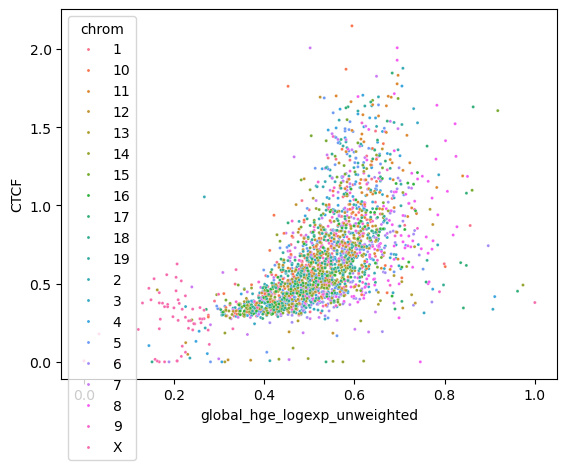

In [27]:
sns.scatterplot(
    data=adata.obs,
    x='global_hge_logexp_unweighted',
    y='CTCF',
    hue='chrom',
    s=5,
)

In [10]:
obs = adata.obs.copy()
test = obs[(obs['global_hge_logexp_RNA_weighted'] > 0.8) & (obs['hge_logexp_RNA_weighted'] < 0.2)]
test

,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,ATACSeq_1,...,ce_betweenness_centrality,ce_pagerank,hge_singular_vector_1,hge_logexp_unweighted,hge_logexp_degree_weighted,hge_logexp_RNA_weighted,hge_logexp_ATAC_weighted,global_singular_vector_1,global_hge_logexp_unweighted,global_hge_logexp_RNA_weighted
bin_name,,,,,,,,,,,,,,,,,,,,,
chr1:41,1602,41000000,42000000,41,1,41,3206,Gm29260;Gm28634;4930448I06Rik,3,0.469957,...,0.009627,0.492098,0.486372,0.547270,0.692558,0.000000,0.208216,0.444785,0.476914,0.937922
chr3:143,1396,143000000,144000000,521,3,143,3700,Gm43616;Gm42706;Gm46828;Gm33651;Gm42707;Lmo4;G...,20,0.696310,...,0.016764,0.799738,0.630252,0.982399,0.690372,0.018251,0.733854,0.623842,0.485992,0.977649
chr7:91,1715,91000000,92000000,1088,7,91,3068,Gm45130;Gm44679;Gm44677;Dlg2;C030038I04Rik;Gm4...,11,0.620721,...,0.046578,0.502819,0.687018,0.987106,0.682363,0.006731,0.788607,0.422121,0.398570,0.961087
chr10:16,2451,16000000,17000000,1414,10,16,3126,Gm18039;Gm47729;Gm5948;Gm18557;Gm20125;Gm55901...,8,0.433311,...,0.024156,0.479994,0.198049,0.477080,0.452247,0.000000,0.112073,0.422411,0.472494,0.974024
chr16:40,2556,40000000,41000000,2164,16,40,3163,Lsamp,1,0.572093,...,0.156934,0.547671,0.646502,0.925424,0.652881,0.000000,0.417018,0.466370,0.398598,0.892457
chr19:51,2233,51000000,52000000,2461,19,51,2838,Gm50330;Gm25644;Gm50317;Gm50325;Gm50326;Rpl31-...,7,0.494841,...,0.530612,0.338348,0.422961,0.983911,0.531462,0.000000,0.360965,0.345010,0.373819,1.000000


In [ ]:
break

In [ ]:
break

In [ ]:
n_reads = 10000

H = adata.to_df().sample(n_reads, axis=1)
print(f"{H.shape=}")
H = ut.sort_by_lowest_index(H)

rows, cols = np.nonzero(H)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4

plt.scatter(
    cols, rows, 
    marker="s",
    s=1,
    c='lightgrey',
    alpha=0.75,
)

plt.gca().invert_yaxis()
plt.xticks([])

sns.despine()

plt.show()

In [ ]:
break

In [ ]:
dpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/core_scores/"

file_list = sorted(glob.glob(f"{dpath}*_{resolution}_*"))
print(f"{len(file_list)} files")

read_columns = [
    'bin_name',
    'ce_singular_vector_1', 
    'ce_eigenvector_centrality',
    'ce_betweenness_centrality',
    'ce_pagerank',
    'hge_singular_vector_1',
    'hge_logexp_unweighted',
    'hge_logexp_degree_weighted',
    'hge_logexp_RNA_weighted',
    'hge_logexp_ATAC_weighted',
]

df = []

for fpath in file_list:
    tmp = pd.read_csv(fpath, usecols=read_columns)
    df.append(tmp)

df = pd.concat(df, ignore_index=True)
df = df.set_index('bin_name')
print(f"{df.shape=}")
df.head()

In [ ]:
adata.obs = pd.merge(
    adata.obs, 
    df, 
    how='left',
    left_index=True,
    right_index=True,
    
)
adata.obs.head()